### Imports and load the data

In [2]:
from showupforhealth.utils import perform_train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 40)
import numpy as np
from imblearn.over_sampling import SMOTE
import time
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.metrics import Recall
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
from sklearn.metrics import f1_score
import keras_tuner as kt
from showupforhealth.ml_functions.predict import make_predict
from showupforhealth.utils import fit_scaler, transform_data
import datetime

# DL model

### Load and shuffle the data

In [3]:
data = pd.read_csv('/Users/alessio/code/janduplessis883/data-showup/data/output-data/full_train_data.csv').sample(frac = 1)

In [4]:
data.head(3)

,Appointment_status,Patient ID,temp,precipitation,Age,Sex,FRAILTY,DEPRESSION,OBESITY,IHD,DM,HPT,NDHG,SMI,IMD2023,dist_to_station,distance_to_surg,book_to_app_days,booked_by_clinician,registered_for_months,sin_week,cos_week,sin_Appointment_time,cos_Appointment_time,sin_month,cos_month,sin_day_of_week,cos_day_of_week,No_shows,Rota_ARRS,Rota_GP,Rota_HCA,Rota_Nurse,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Mixed,Ethnicity_Other,Ethnicity_White
338440,1.0,17734654.0,12.6,0.0,72.0,0.0,0.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11753.0,0.630830,0.822986,0.0,0.0,29.0,-1.000000,-1.836970e-16,0.500000,-0.866025,-1.000000e+00,-1.836970e-16,0.974928,-0.222521,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
306273,1.0,25663170.0,18.4,0.4,52.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28371.0,0.401934,0.838921,14.0,0.0,5.0,-0.885456,-4.647232e-01,0.707107,-0.707107,-1.000000e+00,-1.836970e-16,0.433884,-0.900969,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
137621,0.0,42550043.0,4.0,0.0,36.0,0.0,0.14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3564.0,0.710699,0.284502,1.0,0.0,40.0,-0.354605,9.350162e-01,0.707107,-0.707107,-2.449294e-16,1.000000e+00,-0.433884,-0.900969,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
data_DNA = data[data['Appointment_status']==0]
data_DNA.shape

(21909, 38)

In [6]:
data_NOT_DNA = data[data['Appointment_status']==1][:80000]
data_NOT_DNA.shape

(80000, 38)

In [7]:
data_balanced = pd.concat([data_DNA, data_NOT_DNA]).sample(frac = 1)
data_balanced['Appointment_status'].value_counts()

1.0    80000
0.0    21909
Name: Appointment_status, dtype: int64

In [8]:
data_balanced.head(3)

,Appointment_status,Patient ID,temp,precipitation,Age,Sex,FRAILTY,DEPRESSION,OBESITY,IHD,DM,HPT,NDHG,SMI,IMD2023,dist_to_station,distance_to_surg,book_to_app_days,booked_by_clinician,registered_for_months,sin_week,cos_week,sin_Appointment_time,cos_Appointment_time,sin_month,cos_month,sin_day_of_week,cos_day_of_week,No_shows,Rota_ARRS,Rota_GP,Rota_HCA,Rota_Nurse,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Mixed,Ethnicity_Other,Ethnicity_White
187303,1.0,19077819.0,25.0,0.0,100.0,0.0,0.44,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20040.0,1.056940,0.239398,0.0,0.0,6.0,-0.464723,-0.885456,-0.258819,-0.965926,-0.5,-8.660254e-01,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
436396,1.0,17714107.0,2.0,0.0,79.0,0.0,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8243.0,0.366451,2.858529,7.0,0.0,34.0,0.464723,0.885456,-0.707107,-0.707107,0.5,8.660254e-01,0.974928,-0.222521,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
309594,1.0,27044291.0,17.0,0.0,38.0,0.0,0.06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,23245.0,0.460369,0.625623,2.0,0.0,14.0,-0.970942,-0.239316,0.707107,-0.707107,-1.0,-1.836970e-16,0.974928,-0.222521,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Split in X and y

In [9]:
X = data_balanced.drop(columns=['Appointment_status', 'Patient ID'])
y = data_balanced['Appointment_status']

### Baseline accuracy

In [10]:
print(f'The baseline accuracy if we assume that all patients will show-up is {y.value_counts()[1] / X.shape[0]}')

The baseline accuracy if we assume that all patients will show-up is 0.7850140811900813


### Split in Train and Test

In [11]:
X_train, X_test, y_train, y_test = perform_train_test_split(X,y)

✅ OUTPUT: X_train, X_test, y_train, y_test
Train Set:  X_train, y_train - (81527, 36), (81527,)
 Test Set:  X_test, y_test - - (20382, 36), (20382,)


### Global Scaler

In [12]:
global_scaler = fit_scaler(X_train)
X_train_scaled = transform_data(X_train, global_scaler)
X_test_scaled = transform_data(X_test, global_scaler)

### Split Train and Validation

In [13]:
X_train_val, X_val, y_train_val, y_val = perform_train_test_split(X_train_scaled, y_train)

✅ OUTPUT: X_train, X_test, y_train, y_test
Train Set:  X_train, y_train - (65221, 36), (65221,)
 Test Set:  X_test, y_test - - (16306, 36), (16306,)


# Model

### Define Metrics

In [14]:
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.AUC(name='auc')]

2023-09-17 09:57:02.989758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model 1

In [14]:
%%time
model_one = Sequential()
es = EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)

model_one.add(layers.Dense(112, activation='relu', input_dim=X.shape[1]))
model_one.add(layers.Dropout(0.2))
model_one.add(layers.Dense(32, activation='relu'))
model_one.add(layers.Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model_one.compile(loss='binary_crossentropy', optimizer=adam, metrics=metrics)

history_one = model_one.fit(X_train_val, y_train_val, validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=300,
                    shuffle=True,
                    verbose=0,
                    callbacks=[es])

results = model_one.evaluate(X_test_scaled, y_test)
print(f'Model {model_one.metrics_names[0]} is {results[0]}')
print(f'Model {model_one.metrics_names[1]} is {results[1]}')
print(f'Model {model_one.metrics_names[2]} is {results[2]}')
print(f'Model {model_one.metrics_names[3]} is {results[3]}')
print(f'Model {model_one.metrics_names[4]} is {results[4]}')

762/762 [==============================] - 1s 1ms/step - loss: 0.2240 - accuracy: 0.9046 - recall: 0.9701 - precision: 0.9180 - auc: 0.9403
Model loss is 0.22395670413970947
Model accuracy is 0.9045607447624207
Model recall is 0.9700812101364136
Model precision is 0.9179589152336121
Model auc is 0.940287172794342
CPU times: user 4min 43s, sys: 47.3 s, total: 5min 31s
Wall time: 3min 23s


In [27]:
model_one_pred = model_one.predict(X_test_scaled)
model_one_pred = (model_one_pred > 0.5).astype(np.float32)
model_one_pred

762/762 [==============================] - 1s 996us/step


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

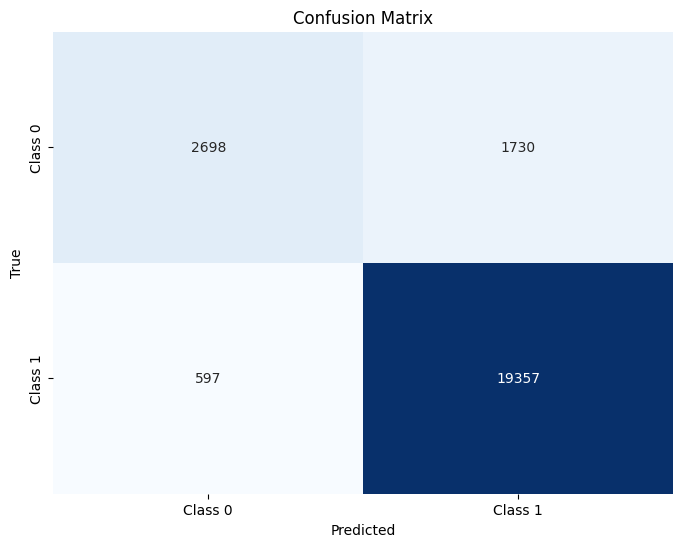

In [28]:
confusion = confusion_matrix(y_test, model_one_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


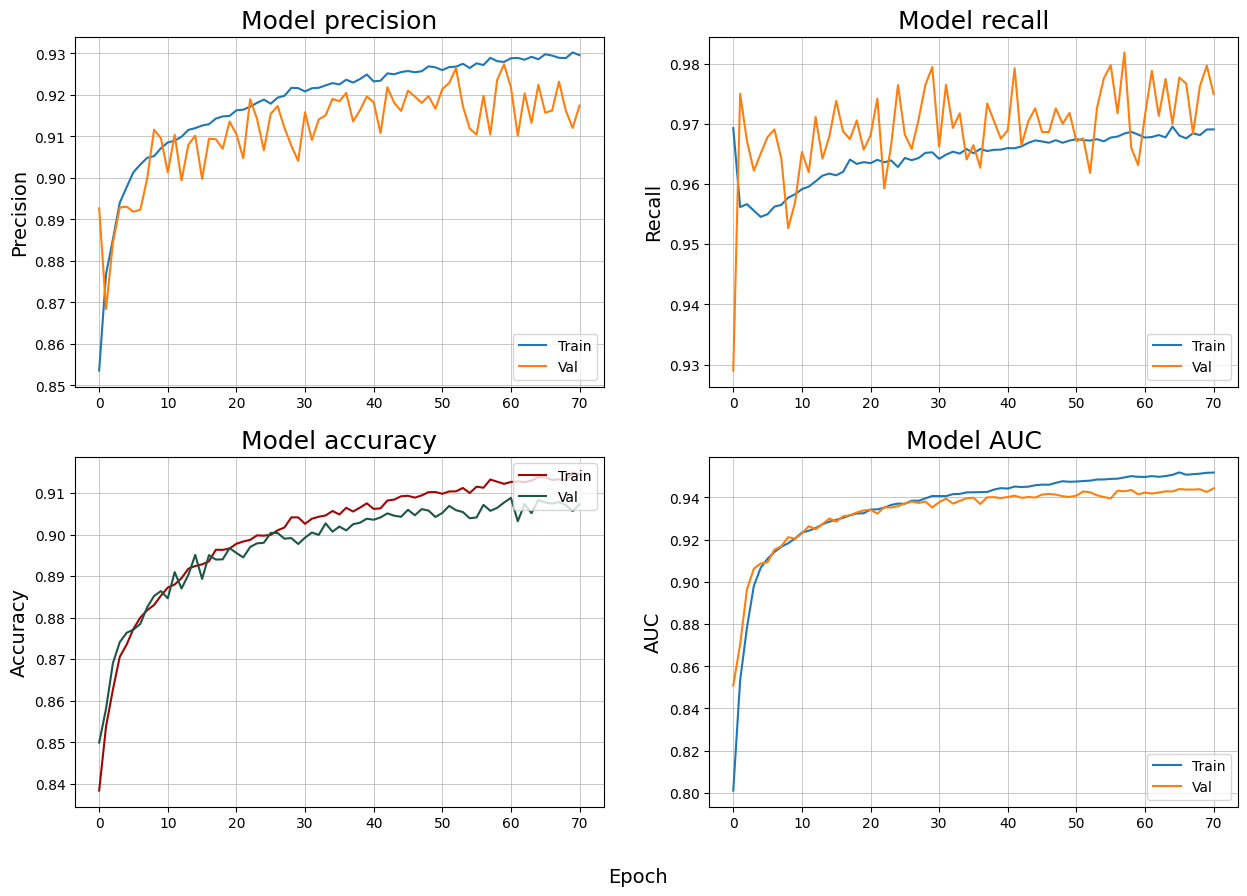

In [17]:
plot_loss_precision_recall_curve(history_one)

### Plot curves function

In [15]:
def plot_loss_precision_recall_curve(history):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

        # --- ACCURACY 
    ax[1, 0].plot(history.history['accuracy'], color="#a10606")
    ax[1, 0].plot(history.history['val_accuracy'], color="#1b5743")
    ax[1, 0].set_title('Model accuracy', fontsize = 18)
    ax[1, 0].set_ylabel('Accuracy', fontsize = 14)
    ax[1, 0].legend(['Train', 'Val'], loc='upper right')
    ax[1, 0].grid(axis="x", linewidth=0.5)
    ax[1, 0].grid(axis="y", linewidth=0.5)
    
    # --- LOSS 
#     ax[0, 0].plot(history.history['loss'], color="#a10606")
#     ax[0, 0].plot(history.history['val_loss'], color="#1b5743")
#     ax[0, 0].set_title('Model loss', fontsize = 18)
#     ax[0, 0].set_ylabel('Loss', fontsize = 14)
#     ax[0, 0].legend(['Train', 'Val'], loc='upper right')
#     ax[0, 0].grid(axis="x", linewidth=0.5)
#     ax[0, 0].grid(axis="y", linewidth=0.5)

#     --- RECALL
    ax[0, 1].plot(history.history['recall']) 
    ax[0, 1].plot(history.history['val_recall'])
    ax[0, 1].set_title('Model recall', fontsize = 18)
    ax[0, 1].set_ylabel('Recall', fontsize = 14) 
    ax[0, 1].legend(['Train', 'Val'], loc='lower right')
    ax[0, 1].grid(axis="x", linewidth=0.5)
    ax[0, 1].grid(axis="y", linewidth=0.5)

#     --- PRECISION
    ax[0,0].plot(history.history['precision'])
    ax[0,0].plot(history.history['val_precision'])
    ax[0,0].set_title('Model precision', fontsize = 18)
    ax[0,0].set_ylabel('Precision', fontsize = 14)
    ax[0,0].legend(['Train', 'Val'], loc='lower right')
    ax[0,0].grid(axis="x", linewidth=0.5)
    ax[0,0].grid(axis="y", linewidth=0.5)
    
    # --- AUC
    ax[1, 1].plot(history.history['auc'])
    ax[1, 1].plot(history.history['val_auc'])
    ax[1, 1].set_title('Model AUC', fontsize = 18) 
    ax[1, 1].set_ylabel('AUC', fontsize = 14)
    ax[1, 1].legend(['Train', 'Val'], loc='lower right')
    ax[1, 1].grid(axis="x", linewidth=0.5)
    ax[1, 1].grid(axis="y", linewidth=0.5)

    # Set common labels  
    fig.text(0.5, 0.04, 'Epoch', ha='center', va='center', fontsize=14) 
    plt.show()

### Keras tuner Model 1

In [27]:
def model_builder(hp):
    model = Sequential()
    
    hp_units_1 = hp.Int('units_1', min_value=16, max_value=256, step=16)
    hp_units_2 = hp.Int('units_2', min_value=16, max_value=256, step=16)
    hp_units_3 = hp.Int('units_3', min_value=16, max_value=256, step=16)
    hp_units_4 = hp.Int('units_4', min_value=16, max_value=256, step=16)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])

    model.add(layers.Dense(units=hp_units_1, activation='relu', input_dim=X.shape[1]))
    model.add(layers.Dense(units=hp_units_2, activation='relu'))
    model.add(layers.Dense(units=hp_units_3, activation='relu'))
    model.add(layers.Dense(units=hp_units_4, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))

    adam = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=metrics)
    return model

In [28]:
LOG_DIR = f'{int(time.time())}'
tuner_kt_1 = kt.RandomSearch(model_builder,
                     objective=kt.Objective('val_auc', direction="max"),
                     directory=f'/Users/alessio/Desktop/kt-logs/{LOG_DIR}')

stop_early = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)
                     
tuner_kt_1.search(X_train_val, y_train_val, validation_data=(X_val, y_val),
             epochs=200,
             callbacks=[stop_early])

Trial 10 Complete [00h 04m 09s]
val_auc: 0.9119246602058411

Best val_auc So Far: 0.9119246602058411
Total elapsed time: 00h 20m 30s
INFO:tensorflow:Oracle triggered exit


In [29]:
best_hps=tuner_kt_1.get_best_hyperparameters(num_trials=1)[0]
best_hps.__dict__

{'_name_scopes': [],
 '_conditions': [],
 '_hps': defaultdict(list,
             {'units_1': [Int(name: 'units_1', min_value: 16, max_value: 256, step: 16, sampling: linear, default: 16)],
              'units_2': [Int(name: 'units_2', min_value: 16, max_value: 256, step: 16, sampling: linear, default: 16)],
              'units_3': [Int(name: 'units_3', min_value: 16, max_value: 256, step: 16, sampling: linear, default: 16)],
              'units_4': [Int(name: 'units_4', min_value: 16, max_value: 256, step: 16, sampling: linear, default: 16)],
              'learning_rate': [Choice(name: 'learning_rate', values: [0.1, 0.01, 0.001], ordered: True, default: 0.1)]}),
 '_space': [Int(name: 'units_1', min_value: 16, max_value: 256, step: 16, sampling: linear, default: 16),
  Int(name: 'units_2', min_value: 16, max_value: 256, step: 16, sampling: linear, default: 16),
  Int(name: 'units_3', min_value: 16, max_value: 256, step: 16, sampling: linear, default: 16),
  Int(name: 'units_4', min_

In [30]:
# TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir)
# EarlyStopping
es = EarlyStopping(patience=50, monitor='val_auc', restore_best_weights=True)

In [31]:
# Build Model with Best hyperparamethers
model_kt_1 = tuner_kt_1.hypermodel.build(best_hps)
# Train model
history_kt_1 = model_kt_1.fit(X_train_val, y_train_val, validation_data=(X_val, y_val),
                    epochs=500,
                    batch_size=128,
                    verbose=0,
                    callbacks=[es, tensorboard])

In [32]:
# Save model
MODEL_NAME = f'80k1_21k0_model_kt_1_{int(time.time())}'
model_kt_1.save(f'{MODEL_NAME}.keras')

In [33]:
model_kt_1.evaluate(X_test_scaled, y_test)

637/637 [==============================] - 1s 1ms/step - loss: 0.2948 - accuracy: 0.8583 - recall: 0.9219 - precision: 0.8997 - auc: 0.9149


[0.29478421807289124,
 0.858306348323822,
 0.9219062924385071,
 0.8997066617012024,
 0.9148778915405273]

In [43]:
# Callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir)
es = EarlyStopping(patience=20, monitor='val_auc', restore_best_weights=True)

model_one = Sequential()
model_one.add(layers.Dense(48, activation='relu', input_dim=X.shape[1]))
model_one.add(layers.Dropout(0.3))
model_one.add(layers.Dense(224, activation='relu'))
model_one.add(layers.Dropout(0.2))
model_one.add(layers.Dense(96, activation='relu'))
model_one.add(layers.Dropout(0.2))
model_one.add(layers.Dense(192, activation='relu'))
model_one.add(layers.Dropout(0.2))
model_one.add(layers.Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_one.compile(loss='binary_crossentropy', optimizer=adam, metrics=metrics)

history_one = model_one.fit(X_train_val, y_train_val, validation_data=(X_val, y_val),
                    batch_size=16,
                    epochs=500,
                    verbose=0,
                    callbacks=[es,tensorboard])

results = model_one.evaluate(X_test_scaled, y_test)
print(f'Model {model_one.metrics_names[0]} is {results[0]}')
print(f'Model {model_one.metrics_names[1]} is {results[1]}')
print(f'Model {model_one.metrics_names[2]} is {results[2]}')
print(f'Model {model_one.metrics_names[3]} is {results[3]}')
print(f'Model {model_one.metrics_names[4]} is {results[4]}')

637/637 [==============================] - 1s 1ms/step - loss: 0.2966 - accuracy: 0.8575 - recall: 0.9149 - precision: 0.9043 - auc: 0.9147
Model loss is 0.29663175344467163
Model accuracy is 0.85747230052948
Model recall is 0.9148922562599182
Model precision is 0.9043020606040955
Model auc is 0.9147406220436096


In [46]:
model_one.save('model_two.h5')

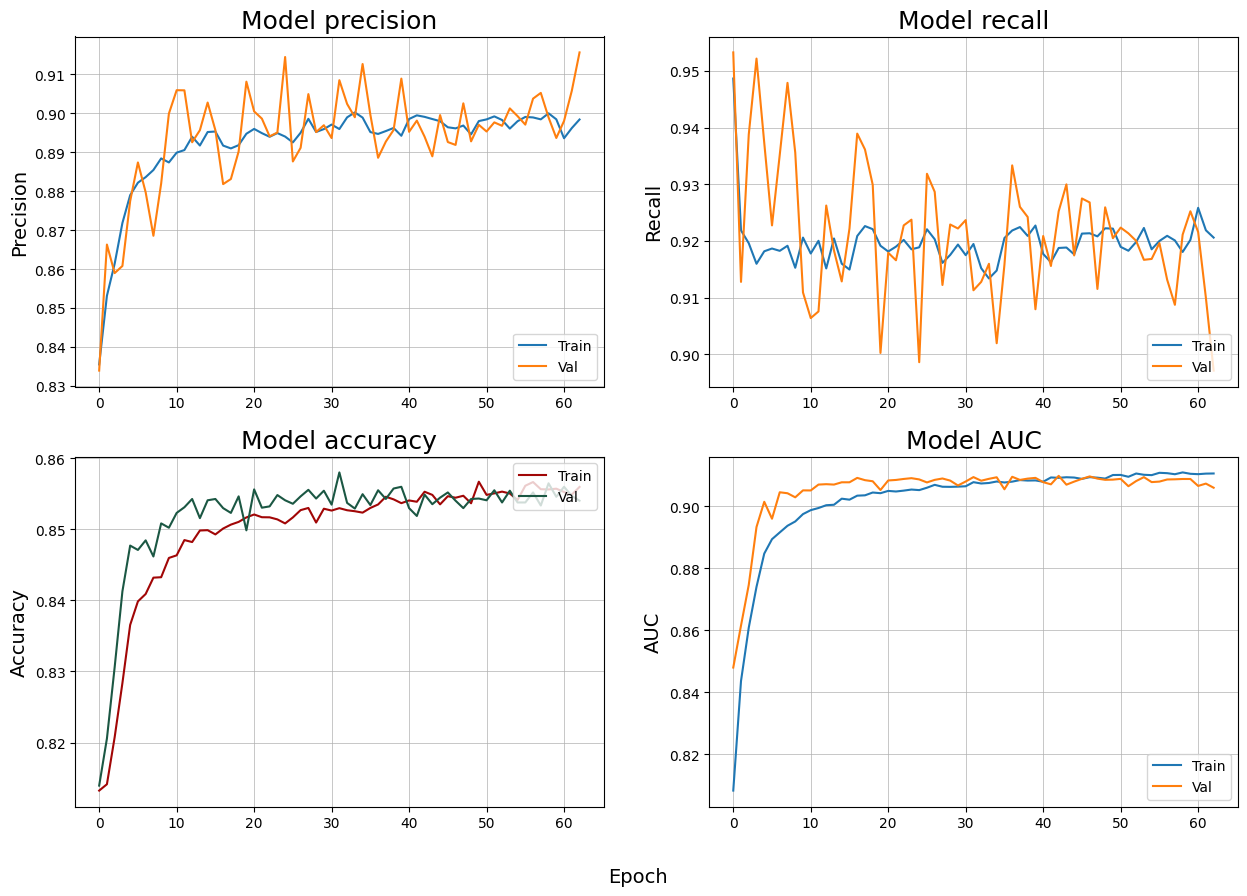

In [41]:
plot_loss_precision_recall_curve(history_one)